# Libraries

In [1]:
#Load all important libraries
import http.client
import json
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt 
from openai import OpenAI
import re
import spacy
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
import math

# Data Loading

In [2]:
# Generating some example data
week = 46
month = 11
monat = 'November'
HotelName = 'Aparthotel Adagio Frankfurt City Messe'
City = 'Frankfurt'
Street = 'Hamburger Allee 4 '
id = 1758394 # this is hotel_id

In [3]:
#Load the Data_Frames: General, Placeholder, Neg, Pos
df_gen = pd.read_excel('../'+str(id)+"/General "+str(id)+".xlsx")
df_neg = pd.read_excel('../'+str(id)+"/Neg "+str(id)+".xlsx")
df_pos = pd.read_excel('../'+str(id)+"/Pos "+str(id)+".xlsx")
df_placeholder = pd.read_excel('../'+str(id)+'/Month_'+str(month)+'/placeholder_month_'+str(month)+'_id_'+str(id)+'.xlsx')

# Process Data only October and November

In [4]:
# Take only Cells from Nov Comments
df_gen['Woche'] = df_gen['Comment_Date'].dt.isocalendar().week
df_gen['Month'] = df_gen['Comment_Date'].dt.month

In [5]:
# Oktober / november: Monthly Highlights
df_sub_month_gen=df_gen[(df_gen['Month']==month)].copy() #<---- Brauche Nicht
df_sub_pmonth_gen=df_gen[(df_gen['Month']==month-1)].copy() #<---- Für Monthly Highlights

In [6]:
print(len(df_sub_pmonth_gen))
print(len(df_sub_month_gen))

40
23


In [7]:
# Take only Cells from 4.Nov to 10.Nov Comments
df_pos['Month'] = df_pos['Date'].dt.month
# Oktober / November: Monthly Highlights
df_sub_month_pos=df_pos[(df_pos['Month']==month)].copy() #<---- Brauche Nicht
df_sub_pmonth_pos=df_pos[(df_pos['Month']==month-1)].copy() #<---- Für Monthly Highlights

In [8]:
# Take only Cells from 4.Nov to 10.Nov Comments
df_neg['Month'] = df_neg['Date'].dt.month
# Oktober / November: Monthly Highlights
df_sub_month_neg=df_neg[(df_neg['Month']==month)].copy() #<---- Brauche Nicht
df_sub_pmonth_neg=df_neg[(df_neg['Month']==month-1)].copy() #<---- Für Monthly Highlights

# Weekly Highlights

## Data Overview

### Score November / October

In [9]:
# overview score
df_sub_month_gen["Score"].describe()
df_sub_month_gen['Score'].value_counts()
counts = df_sub_month_gen['Score'].value_counts().sum()

count    23.000000
mean      8.782609
std       1.241572
min       5.000000
25%       8.000000
50%       9.000000
75%      10.000000
max      10.000000
Name: Score, dtype: float64

In [12]:
# Speicher für die Placeholder DF die nötigen Werte für den Text ab.
score_min=df_sub_month_gen["Score"].describe()['min']
score_max=df_sub_month_gen["Score"].describe()['max']
score_mean=df_sub_month_gen["Score"].describe()['mean']
score_q1=df_sub_month_gen["Score"].describe()['25%']
score_q2=df_sub_month_gen["Score"].describe()['75%']
score_min

5.0

In [13]:
# Füge die Daten in dem Mustertext ein
score_text = 'Score Distribution:\nThe boxplot shows the distribution of scores. The lowest rating given was a ' + str(round(score_min)) + ', the highest rating given was a ' + str(round(score_max)) + '. The average rating is ' + str(round(score_mean, 2)) + ', with 50% of guests rating the hotel between ' + str(round(score_q1, 2)) + ' and ' + str(round(score_q2, 2)) + '.'

In [14]:
# Speicher den Text in den Placeholder DataFrame
df_placeholder.loc[df_placeholder["Placeholder"]=='{{Score_Week}}','Content']=score_text

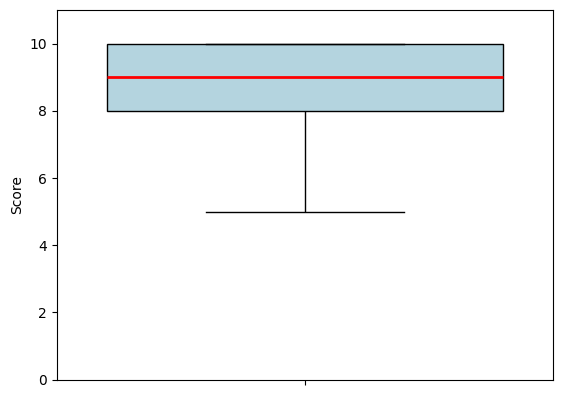

In [15]:
# Create a box plot
sns.boxplot(y='Score', data=df_sub_month_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

# Add labels and title
plt.ylabel('Score')
plt.ylim(0,11)

plt.savefig('../'+str(id)+"/Month_"+str(month)+"/score.png",bbox_inches='tight')
# Show plot
plt.show()


In [16]:
score_levels=[0]
text=''
j=0
for i in range(1,11):
    score_levels.append(df_sub_month_gen["Score"].value_counts().get(i,0))
    if score_levels[i] > 1:
        text = text + 'The score level ' + str(i) + ' has received ' + str(score_levels[i]) + ' ratings (' + str(round(100 * score_levels[i] / counts, 1)) + '%). '
    elif score_levels[i] == 1:
        text = text + 'The score level ' + str(i) + ' has received one rating (' + str(round(100 * score_levels[i] / counts, 1)) + '%). '
    else:
        j=1
if j==1:
    text = text + 'No ratings were given for the other score levels.'
sum(score_levels)        

23

In [17]:
score_level_text = 'Score-Level Distribution:\nThe bar plot shows the score values for each score level. A total of ' + str(sum(score_levels)) + ' ratings were given. ' + text

In [18]:
# Speicher den Text in den Placeholder DataFrame
df_placeholder.loc[df_placeholder["Placeholder"]=='{{Score_Level_Week}}','Content']=score_level_text

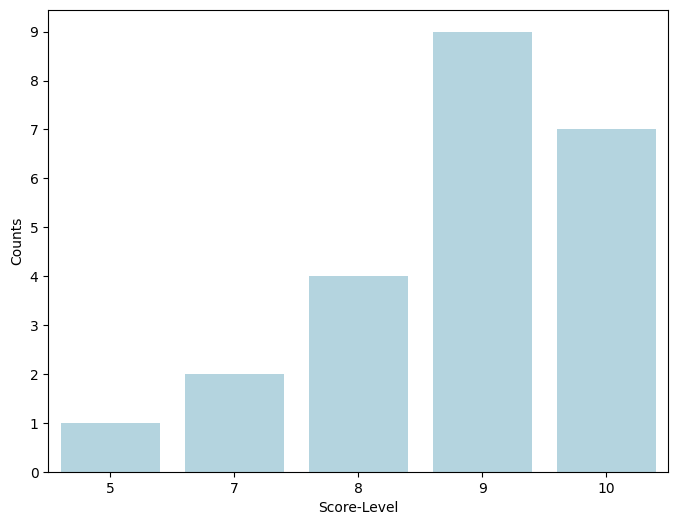

In [19]:
# Erstelle den Barplot
plt.figure(figsize=(8, 6))  # Größe des Diagramms anpassen
sns.barplot(df_sub_month_gen["Score"].value_counts(), color='lightblue', legend=False)

# Füge Titel und Labels hinzu
#plt.title('Count der Score-Level')
plt.xlabel('Score-Level')
plt.ylabel('Counts')
# Setze die y-Achse so, dass nur ganze Zahlen angezeigt werden
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/score_level.png",bbox_inches='tight')
# Zeige das Diagramm an
plt.show()


### Customer Type Distribution

In [20]:
df_sub_month_gen["Customer_Type"].describe()

count                 23
unique                 4
top       Solo traveller
freq                   7
Name: Customer_Type, dtype: object

In [21]:
df_sub_month_gen["Customer_Type"].value_counts()

Customer_Type
Solo traveller      7
Group of friends    7
Couple              5
Family              4
Name: count, dtype: int64

In [22]:
# Definiere die Kennzahlen für den Text
customer_count = df_sub_month_gen['Customer_Type'].value_counts().sum()
customer_typen = df_sub_month_gen["Customer_Type"].value_counts().index.tolist()

In [23]:
# Konstruiere den Dynamischen Text für ein Kreisdiagram
customer_types=[0]
customer_text1=''
j=0
for i in df_sub_month_gen["Customer_Type"].value_counts().index.tolist():
    k=df_sub_month_gen["Customer_Type"].value_counts().get(i,0)
    customer_types.append(k)
    if k > 1:
        customer_text1 = customer_text1 + 'The customer class ' + i + ' has given ' + str(k) + ' ratings (' + str(round((k / customer_count) * 100, 1)) + '%). '
    elif k == 1:
        customer_text1 = customer_text1 + 'The customer class ' + i + ' has given one rating (' + str(round(100 / customer_count, 1)) + '%). '
    else:
        j=1
if j==1:
    customer_text1 = customer_text1 + 'No ratings were given for the other customer types.'
sum(customer_types)  

23

In [24]:
# Erstelle den Text für den Placeholder
customer_text = 'Customer Type Distribution:\nThe pie chart shows the proportions of different customer types. The ' + str(customer_count) + ' guest ratings are divided into the following customer types: ' + str(', '.join(customer_typen)) + '. ' + customer_text1

In [25]:
# Speicher den Text in dem Placeholder DataFrame
df_placeholder.loc[df_placeholder['Placeholder']=='{{Customer_Week}}','Content']=customer_text

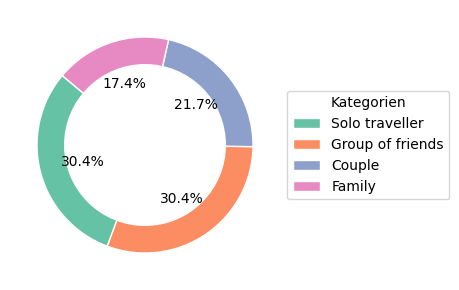

In [26]:
# Verwende die Seaborn-Farbpalette
colors = sns.color_palette("Set2", len(df_sub_month_gen["Customer_Type"].value_counts()))  # 'Set2' Palette

# Erstelle das Kreisdiagramm mit benutzerdefinierten Farben
plt.figure(figsize=(8, 3))
plt.pie(df_sub_month_gen["Customer_Type"].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)
# Füge Titel hinzu
#plt.title('Kreisdiagramm mit Legende rechts')

# Positioniere die Legende rechts neben dem Diagramm
plt.legend(df_sub_month_gen["Customer_Type"].value_counts().index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/customer.png",bbox_inches='tight')
# Zeige das Diagramm an
plt.show()


### Comment Statistics Overview

In [27]:
df_sub_month_gen["Positiv"].describe()

count                                                     9
unique                                                    9
top       La posizione comoda per raggiungere i luoghi d...
freq                                                      1
Name: Positiv, dtype: object

In [28]:
df_sub_month_gen["Negativ"].describe()

count                       9
unique                      9
top       Nulla da segnalare.
freq                        1
Name: Negativ, dtype: object

In [29]:
positiv_counts = df_sub_month_gen["Positiv"].describe()['count']
negativ_counts = df_sub_month_gen["Negativ"].describe()['count']
pos_neg_sum = positiv_counts+negativ_counts
pos_neg_text = 'Positive-Negative Distribution:\nThis week, there were ' + str(positiv_counts) + ' positive (' + str(round(100 * positiv_counts / pos_neg_sum, 1)) + '%) and ' + str(negativ_counts) + ' negative (' + str(round(100 * negativ_counts / pos_neg_sum, 1)) + '%) comments, with a customer being able to write both positive and negative feedback.'
df_placeholder.loc[df_placeholder['Placeholder']=='{{Pos_Neg}}',['Content']]=pos_neg_text
pos_neg_text

'Positive-Negative Distribution:\nThis week, there were 9 positive (50.0%) and 9 negative (50.0%) comments, with a customer being able to write both positive and negative feedback.'

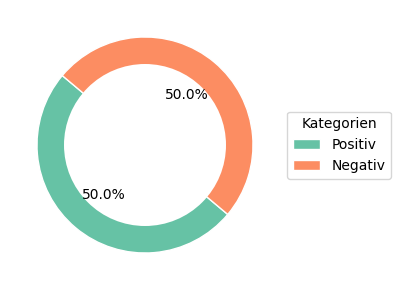

In [30]:
pos_neg_size = [df_sub_month_gen["Positiv"].describe()["count"],df_sub_month_gen["Negativ"].describe()["count"]]
pos_neg_label = ["Positiv","Negativ"]
# Verwende die Seaborn-Farbpalette
colors = sns.color_palette("Set2", len(pos_neg_size))  # 'Set2' Palette

# Erstelle das Kreisdiagramm mit benutzerdefinierten Farben
plt.figure(figsize=(8, 3))
plt.pie(pos_neg_size, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)
# Füge Titel hinzu
#plt.title('Kreisdiagramm mit Legende rechts')

# Positioniere die Legende rechts neben dem Diagramm
plt.legend(pos_neg_label, loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/pos_neg.png",bbox_inches='tight')
# Zeige das Diagramm an
plt.show()


### Room Category Distribution

In [31]:
df_sub_month_gen["Room_Name"].describe()

count                    23
unique                    2
top       Studio (2 Adults)
freq                     16
Name: Room_Name, dtype: object

In [32]:
df_sub_month_gen["Room_Name"].value_counts()

Room_Name
Studio (2 Adults)    16
Apartment             7
Name: count, dtype: int64

In [33]:
# Definiere die Kennzahlen für den Text
room_count = df_sub_month_gen['Room_Name'].value_counts().sum()
room_typen = df_sub_month_gen['Room_Name'].value_counts().index.tolist()
# Konstruiere den Dynamischen Text für ein Kreisdiagram
room_tpyes=[0]
room_text1=''
j=0
for i in df_sub_month_gen['Room_Name'].value_counts().index.tolist():
    k=df_sub_month_gen['Room_Name'].value_counts().get(i,0)
    room_tpyes.append(k)
    if k > 1:
        room_text1 = room_text1 + 'The guests of ' + i + ' have given ' + str(k) + ' ratings (' + str(round((k / room_count) * 100, 1)) + '%). '
    elif k == 1:
        room_text1 = room_text1 + 'The guest of ' + i + ' has given one rating (' + str(round(100 / room_count, 1)) + '%). '
    else:
        j=1
if j==1:
    room_text1 = room_text1 + 'No ratings were given for the other room types.'
sum(room_tpyes)
# Erstelle den Text für den Placeholder
room_text = 'Room Class Distribution:\nThe pie chart shows the proportions of different room classes. This week, guests have rated the following room classes: ' + str(', '.join(room_typen)) + '. ' + room_text1
# Speicher den Text in dem Placeholder DataFrame
df_placeholder.loc[df_placeholder['Placeholder']=='{{Room_Week}}','Content']=room_text

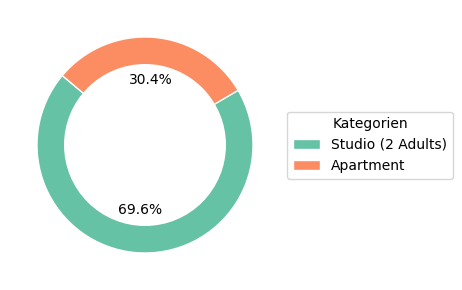

In [34]:
# Verwende die Seaborn-Farbpalette
colors = sns.color_palette("Set2", len(df_sub_month_gen["Room_Name"].value_counts()))  # 'Set2' Palette

# Erstelle das Kreisdiagramm mit benutzerdefinierten Farben
plt.figure(figsize=(8, 3))
plt.pie(df_sub_month_gen["Room_Name"].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)
# Füge Titel hinzu
#plt.title('Kreisdiagramm mit Legende rechts')

# Positioniere die Legende rechts neben dem Diagramm
plt.legend(df_sub_month_gen["Room_Name"].value_counts().index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/room.png",bbox_inches='tight')
# Zeige das Diagramm an
plt.show()


### Travel Purpose Distribution

In [35]:
df_sub_month_gen["Travel_Purpose"].describe()

count          23
unique          3
top       leisure
freq           11
Name: Travel_Purpose, dtype: object

In [36]:
df_sub_month_gen["Travel_Purpose"].value_counts()

Travel_Purpose
leisure     11
business    11
other        1
Name: count, dtype: int64

In [37]:
# Definiere die Kennzahlen für den Text
travel_count = df_sub_month_gen['Travel_Purpose'].value_counts().sum()
travel_typen = df_sub_month_gen['Travel_Purpose'].value_counts().index.tolist()
# Konstruiere den Dynamischen Text für ein Kreisdiagram
travel_types=[0]
travel_text1=''
j=0
for i in df_sub_month_gen['Travel_Purpose'].value_counts().index.tolist():
    k=df_sub_month_gen['Travel_Purpose'].value_counts().get(i,0)
    travel_types.append(k)
    if k > 1:
        travel_text1 = travel_text1 + 'Under the travel purpose ' + i + ', a total of ' + str(k) + ' (' + str(round((k / travel_count) * 100, 1)) + '%) ratings were given. '
    elif k == 1:
        travel_text1 = travel_text1 + 'Under the travel purpose ' + i + ', one rating (' + str(round(100 / travel_count, 1)) + '%) was given. '
    else:
        j=1
if j==1:
    travel_text1 = travel_text1 + 'No ratings were given for other travel purposes.'
sum(travel_types)
# Erstelle den Text für den Placeholder
travel_text = 'Travel Purpose Distribution:\nThe pie chart shows the proportions of different travel purposes. Guests traveled for the following reasons: ' + str(', '.join(travel_typen)) + '. ' + travel_text1
# Speicher den Text in dem Placeholder DataFrame
df_placeholder.loc[df_placeholder['Placeholder']=='{{Travel_Week}}','Content']=travel_text

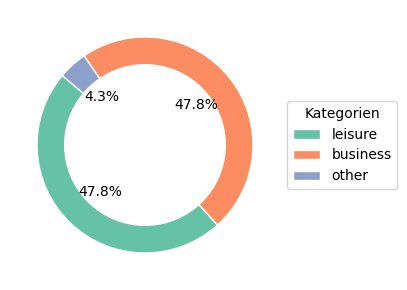

In [38]:
# Verwende die Seaborn-Farbpalette
colors = sns.color_palette("Set2", len(df_sub_month_gen["Travel_Purpose"].value_counts()))  # 'Set2' Palette

# Erstelle das Kreisdiagramm mit benutzerdefinierten Farben
plt.figure(figsize=(8, 3))
plt.pie(df_sub_month_gen["Travel_Purpose"].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)
# Füge Titel hinzu
#plt.title('Kreisdiagramm mit Legende rechts')

# Positioniere die Legende rechts neben dem Diagramm
plt.legend(df_sub_month_gen["Travel_Purpose"].value_counts().index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/travel.png",bbox_inches='tight')
# Zeige das Diagramm an
plt.show()


## Highlights Score

### Score x Room Category

In [39]:
df_sub_month_gen.groupby("Room_Name")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Room_Name,,,,,,,,
Apartment,7.0,8.571429,1.902379,5.0,8.0,9.0,10.00,10.0
Studio (2 Adults),16.0,8.875000,0.885061,7.0,8.0,9.0,9.25,10.0


In [40]:
df_sub_month_gen.groupby("Room_Name")["Score"].value_counts()

Room_Name          Score
Apartment          10       3
                   9        2
                   5        1
                   7        1
Studio (2 Adults)  9        7
                   8        4
                   10       4
                   7        1
Name: count, dtype: int64

In [41]:
score_room_class = df_sub_month_gen.groupby("Room_Name")["Score"].describe().index.tolist()
score_room_class

['Apartment', 'Studio (2 Adults)']

In [42]:
s_r = df_sub_month_gen.groupby("Room_Name")["Score"].describe()
s_r_text = ''
for i in score_room_class:
    mean = s_r['mean'][i]
    if s_r['count'][i]>1:
        minimum=s_r['min'][i]
        maximum=s_r['max'][i]
        q1=s_r['25%'][i]
        q2=s_r['75%'][i]
        s_r_text = s_r_text + ' The class <' + i + '> is rated on average with ' + str(round(mean, 1)) + ' (Red), with the lowest rating of ' + str(minimum) + ' (Left bar) and the highest rating of ' + str(maximum) + ' (Right bar). 50% of the ratings (Blue) are between ' + str(round(q1, 1)) + ' and ' + str(round(q2, 1)) + '.'
    elif s_r['count'][i]==1:
        s_r_text = s_r_text + ' The class <' + i + '> has an average rating of ' + str(round(mean, 1)) + ' (Red). There was only one rating in this class.'

In [43]:
score_room_text = 'Score-Room Class Distribution:\nThe score distribution is shown for the room categories ' + ', '.join(score_room_class) + '. ' + s_r_text

In [44]:
df_placeholder.loc[df_placeholder['Placeholder']=='{{Score_Room}}','Content']=score_room_text

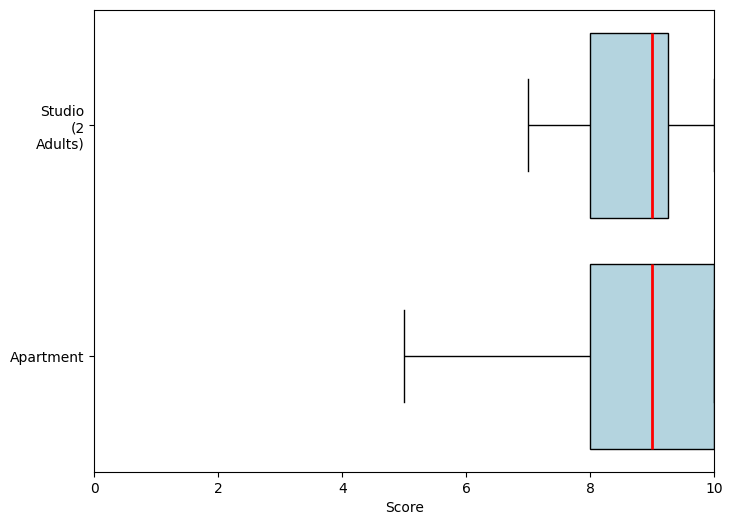

In [45]:
# Erstelle den Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Score', y=[label.replace(' ','\n') for label in df_sub_month_gen['Room_Name']], data=df_sub_month_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

# Füge Titel und Labels hinzu
#plt.title('Boxplot der Scores pro Room_Name')
plt.xlabel('Score')
plt.ylabel("")
plt.xlim(0,10)
plt.xticks(rotation=0)
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/score_room.png",bbox_inches='tight')
# Zeige das Diagramm an
plt.show()


### Score x Travel Purpose

In [46]:
df_sub_month_gen.groupby("Travel_Purpose")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Travel_Purpose,,,,,,,,
business,11.0,8.454545,1.439697,5.0,8.0,9.0,9.0,10.0
leisure,11.0,9.090909,1.044466,7.0,8.5,9.0,10.0,10.0
other,1.0,9.000000,NaN,9.0,9.0,9.0,9.0,9.0


In [47]:
df_sub_month_gen.groupby("Travel_Purpose")["Score"].value_counts()

Travel_Purpose  Score
business        9        5
                8        2
                10       2
                5        1
                7        1
leisure         10       5
                9        3
                8        2
                7        1
other           9        1
Name: count, dtype: int64

In [48]:
score_travel_class = df_sub_month_gen.groupby("Travel_Purpose")["Score"].describe().index.tolist()
s_t = df_sub_month_gen.groupby("Travel_Purpose")["Score"].describe()
s_t_text = ''
for i in score_travel_class:
    mean = s_t['mean'][i]
    if s_t['count'][i]>1:
        minimum=s_t['min'][i]
        maximum=s_t['max'][i]
        q1=s_t['25%'][i]
        q2=s_t['75%'][i]
        s_t_text = s_t_text + ' The class <' + i + '> is rated on average with ' + str(round(mean, 1)) + ' (Red), with the lowest rating of ' + str(minimum) + ' (Left bar) and the highest rating of ' + str(maximum) + ' (Right bar). 50% of the ratings (Blue) are between ' + str(round(q1, 1)) + ' and ' + str(round(q2, 1)) + '.'
    elif s_t['count'][i]==1:
        s_t_text = s_t_text + ' The class <' + i + '> has an average rating of ' + str(round(mean, 1)) + ' (Red). There was only one rating in this class.'
score_travel_text = 'Score-Travel Purpose Distribution:\nThe score distribution is shown for the travel purposes ' + ', '.join(score_travel_class) + '. ' + s_t_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Score_Travel}}','Content']=score_travel_text

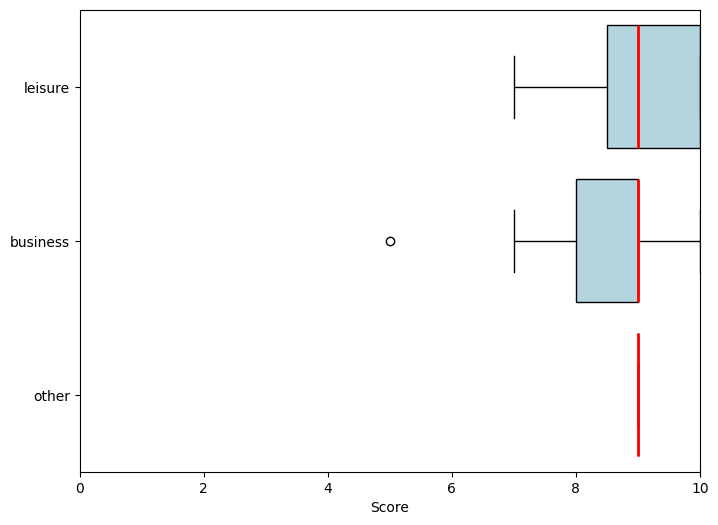

In [49]:
# Erstelle den Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Score', y=[label.replace(' ','\n') for label in df_sub_month_gen['Travel_Purpose']], data=df_sub_month_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

# Füge Titel und Labels hinzu
#plt.title('Boxplot der Scores pro Travel-Purpose')
plt.xlabel('Score')
plt.ylabel("")
plt.xlim(0,10)
plt.xticks(rotation=0)
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/score_travel.png")
# Zeige das Diagramm an
plt.show()


### Score x Customer Type

In [50]:
df_sub_month_gen.groupby("Customer_Type")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Customer_Type,,,,,,,,
Couple,5.0,8.600000,0.894427,7.0,9.00,9.0,9.0,9.0
Family,4.0,9.750000,0.500000,9.0,9.75,10.0,10.0,10.0
Group of friends,7.0,8.571429,1.718249,5.0,8.50,9.0,9.5,10.0
Solo traveller,7.0,8.571429,1.133893,7.0,8.00,8.0,9.5,10.0


In [51]:
df_sub_month_gen.groupby("Customer_Type")["Score"].value_counts()

Customer_Type     Score
Couple            9        4
                  7        1
Family            10       3
                  9        1
Group of friends  9        3
                  10       2
                  5        1
                  8        1
Solo traveller    8        3
                  10       2
                  7        1
                  9        1
Name: count, dtype: int64

In [52]:
score_customer_class = df_sub_month_gen.groupby("Customer_Type")["Score"].describe().index.tolist()
s_c = df_sub_month_gen.groupby("Customer_Type")["Score"].describe()
s_c_text = ''
for i in score_customer_class:
    mean = s_c['mean'][i]
    if s_c['count'][i]>1:
        minimum=s_c['min'][i]
        maximum=s_c['max'][i]
        q1=s_c['25%'][i]
        q2=s_c['75%'][i]
        s_c_text = s_c_text + ' The class <' + i + '> is rated on average with ' + str(round(mean, 1)) + ' (Red), with the lowest rating of ' + str(minimum) + ' (Left bar) and the highest rating of ' + str(maximum) + ' (Right bar). 50% of the ratings (Blue) are between ' + str(round(q1, 1)) + ' and ' + str(round(q2, 1)) + '.'
    elif s_c['count'][i]==1:
        s_c_text = s_c_text + ' The class <' + i + '> has an average rating of ' + str(round(mean, 1)) + ' (Red). There was only one rating in this class.'
score_customer_text = 'Score-Customer Type Distribution:\nThe score distribution is shown for the customer types ' + ', '.join(score_customer_class) + '. ' + s_c_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Score_Customer}}','Content']=score_customer_text

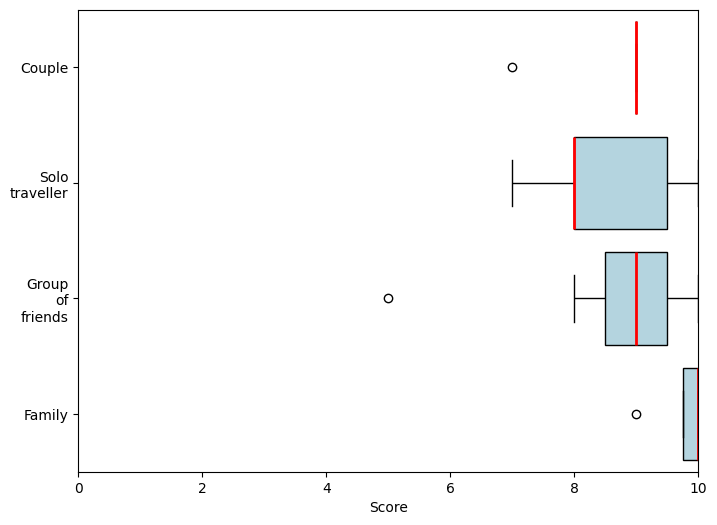

In [53]:
# Erstelle den Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Score', y=[label.replace(' ','\n') for label in df_sub_month_gen['Customer_Type']], data=df_sub_month_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

# Füge Titel und Labels hinzu
#plt.title('Boxplot der Scores pro Customer-Type')
plt.xlabel('Score')
plt.ylabel("")
plt.xticks(rotation=0)
plt.xlim(0,10)
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/score_customer.png")
# Zeige das Diagramm an
plt.show()


## Comparison

### Score x Room Category

In [54]:
a=df_sub_month_gen.groupby("Room_Name")["Score"].describe().copy()
b=df_sub_pmonth_gen.groupby("Room_Name")["Score"].describe().copy()

In [55]:
c=a-b
#type(c["mean"]['Family Studio with City View'])
#c.index.tolist()

In [56]:
d_r_text =''
for i in c.index.tolist():
    if (round(c['mean'][i],2)>0) or (round(c['mean'][i],2)<0):
        d_r_text = d_r_text + 'The class <' + i + '> has changed by an average of ' + str(round(c['mean'][i], 2)) + ' points'
        if round(c['mean'][i],2) > 0:
            d_r_text = d_r_text+' more than the previous week. '
        elif round(c['mean'][i],2) <0:
            d_r_text = d_r_text+' less than the previous week. '
    elif round(c['mean'][i],2)==0:
        d_r_text = d_r_text + 'The rating of the class <'+i+'> did not changed to the previous week. '
    elif math.isnan(round(c['mean'][i],2)):
        d_r_text = d_r_text + 'For the class <'+i+'> there were no ratings received. '
        

In [57]:
diff_room = 'Score-Room Class Comparison:\nThe following changes occurred for the room categories rated this week compared to last week: ' + d_r_text

In [58]:
df_placeholder.loc[df_placeholder['Placeholder']=='{{Diff_Room}}','Content']=diff_room

0.15966386554621792 green
0.2663043478260878 green
0.15966386554621792
0.2663043478260878


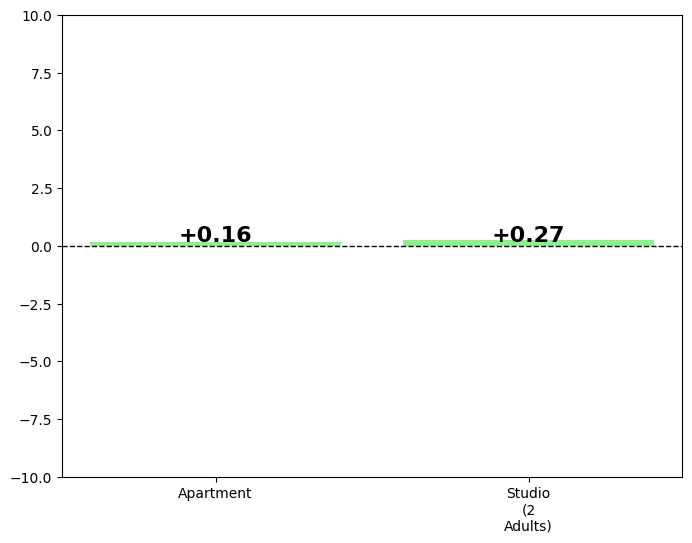

In [59]:
# Plotting the differences
plt.figure(figsize=(8, 6))
# Create a color array based on the value of the 'Difference' column
colors = []
for diff in c['mean']:
    if diff < 0:
        colors.append('red')  # für negative Werte
        print(str(diff)+' red')
    elif diff > 0:
        colors.append('lightgreen')  # für positive Werte
        print(str(diff)+' green')
    elif math.isnan(diff):
        colors.append('black')
        
bars=plt.bar([label.replace(' ','\n') for label in c.index.tolist()], c["mean"], color=colors)
# Adding horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height() # Get the height of the bar (the value)
    print(yval)
    if not math.isnan(yval):
        if yval > 0:
            yval="+"+str(round(yval,2))
        elif yval<0:
            yval=str(round(yval,2))
        plt.text(bar.get_x() + bar.get_width() / 2, 0,  # Position the text
                    yval,  # Display the rounded value
                    ha='center',  # Horizontal alignment of the text
                    va='bottom',  # Vertical alignment of the text
                    color='black' if yval != 0 else 'white',  # Text color based on the value
                    fontweight='bold',  # Make the text bold
                    fontsize=16)  # Set the font size to 12 pt
# Adding labels and title
#plt.xlabel('Category')
#plt.ylabel('Score Unterschied zur')
#plt.title('Differences Between value1 and value2')
# Setze die y-Achsen-Grenzen
plt.ylim(-10,10)  # z. B. von -10 bis 40
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/diff_room.png")
# Display the plot
plt.show()


### Score x Travel Purpose

In [60]:
d=df_sub_month_gen.groupby("Travel_Purpose")["Score"].describe().copy()
e=df_sub_pmonth_gen.groupby("Travel_Purpose")["Score"].describe().copy()

In [61]:
f=d-e
f["mean"]
f.index.tolist()

['business', 'leisure', 'other']

In [62]:
d_t_text =''
for i in f.index.tolist():
    if (round(f['mean'][i],2)>0) or (round(f['mean'][i],2)<0):
        d_t_text = d_t_text + 'The class <'+i+'> has changed by an average of '+str(round(f['mean'][i],2))+' points'
        if round(f['mean'][i],2) > 0:
            d_t_text = d_t_text+' more than the previous week. '
        elif round(f['mean'][i],2) <0:
            d_t_text = d_t_text+' less than the previous week. '
    elif round(f['mean'][i],2)==0:
        d_t_text = d_t_text + 'The ratings of the class <'+i+'> did not changed to the previous week. '
    elif math.isnan(round(f['mean'][i],2)):
        d_t_text = d_t_text + 'For the class <'+i+'> there were no ratings received. '
diff_travel = 'Score-Travel Purpose Comparison:\nThe following changes occurred in the ratings based on the travel purpose compared to last week: ' + d_t_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Diff_Travel}}','Content']=diff_travel

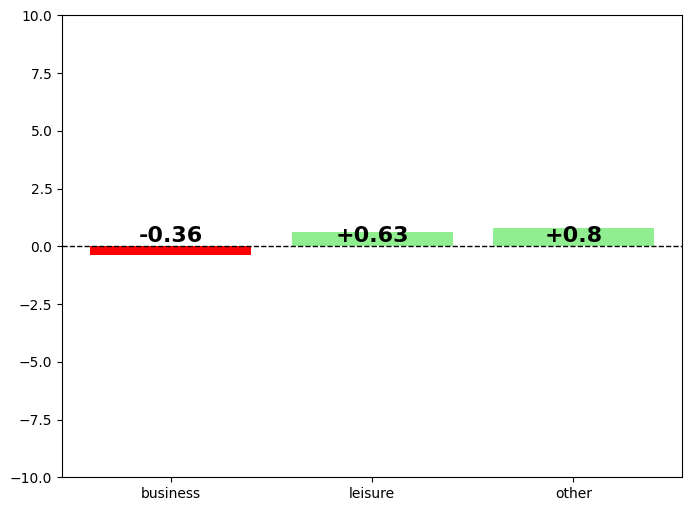

In [63]:
# Plotting the differences
plt.figure(figsize=(8, 6))
# Create a color array based on the value of the 'Difference' column
colors = []
for diff in f['mean']:
    if diff < 0:
        colors.append('red')  # für negative Werte
    elif diff > 0.0:
        colors.append('lightgreen')  # für positive Werte
    elif math.isnan(diff):
        colors.append('black')
        
bars=plt.bar([label.replace(' ','\n') for label in f.index.tolist()], f["mean"], color=colors)
# Adding horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height() # Get the height of the bar (the value)
    if yval > 0:
        yval="+"+str(round(yval,2))
    else:
        yval=str(round(yval,2))
    plt.text(bar.get_x() + bar.get_width() / 2, 0,  # Position the text
             yval,  # Display the rounded value
             ha='center',  # Horizontal alignment of the text
             va='bottom',  # Vertical alignment of the text
             color='black' if yval != 0 else 'white',  # Text color based on the value
             fontweight='bold',  # Make the text bold
             fontsize=16)  # Set the font size to 12 pt
# Adding labels and title
# plt.xlabel('Category')
# plt.ylabel('Difference (value1 - value2)')
# plt.title('Differences Between value1 and value2')
# Setze die y-Achsen-Grenzen
plt.ylim(-10,10)  # z. B. von -10 bis 40
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/diff_travel.png")
# Display the plot
plt.show()

### Score x Customer Type

In [64]:
u=df_sub_month_gen.groupby("Customer_Type")["Score"].describe().copy()
p=df_sub_pmonth_gen.groupby("Customer_Type")["Score"].describe().copy()

In [65]:
r=[]
t=(u-p)
r=t["mean"].dropna()
r

Customer_Type
Couple              0.236364
Family              1.057692
Group of friends    0.154762
Solo traveller     -0.178571
Name: mean, dtype: float64

In [66]:
d_c_text =''
for i in t.index.tolist():
    if (round(t['mean'][i],2)>0) or (round(t['mean'][i],2)<0):
        d_c_text = d_c_text + 'The class <'+i+'> changed by an average of '+str(round(t['mean'][i],2))+' points'
        if round(t['mean'][i],2) > 0:
            d_c_text = d_c_text+' more than the previous week. '
        elif round(t['mean'][i],2) <0:
            d_c_text = d_c_text+' less than the previous week. '
    elif round(t['mean'][i],2)==0:
        d_c_text = d_c_text + 'The rating of the class'+i+' did not changed to the previous week. '
    elif math.isnan(round(t['mean'][i],2)):
        d_c_text = d_c_text + 'For the class'+i+' there were no ratings received. '
diff_customer = 'Score-Customer Type Comparison:\nThe ratings by customer type have changed as follows compared to last week: ' + d_c_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Diff_Customer}}','Content']=diff_customer

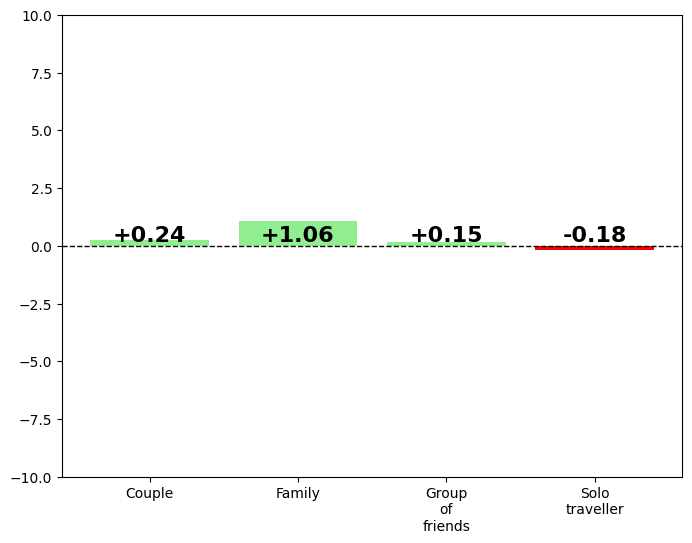

In [67]:
# Plotting the differences
plt.figure(figsize=(8, 6))
# Create a color array based on the value of the 'Difference' column
colors = []
for diff in r:
    if diff < 0:
        colors.append('red')  # für negative Werte
    elif diff > 0.0:
        colors.append('lightgreen')  # für positive Werte
    elif math.isnan(diff):
        colors.append('black')
bars=plt.bar([label.replace(' ','\n') for label in r.index.tolist()], r, color=colors)
# Adding horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height() # Get the height of the bar (the value)
    if yval > 0:
        yval="+"+str(round(yval,2))
    else:
        yval=str(round(yval,2))
    plt.text(bar.get_x() + bar.get_width() / 2, 0,  # Position the text
             yval,  # Display the rounded value
             ha='center',  # Horizontal alignment of the text
             va='bottom',  # Vertical alignment of the text
             color='black' if yval != 0 else 'white',  # Text color based on the value
             fontweight='bold',  # Make the text bold
             fontsize=16)  # Set the font size to 12 pt
# Adding labels and title
# plt.xlabel('Category')
# plt.ylabel('Difference (value1 - value2)')
# plt.title('Differences Between value1 and value2')
# Setze die y-Achsen-Grenzen
plt.ylim(-10,10)  # z. B. von -10 bis 40
plt.savefig('../'+str(id)+"/Month_"+str(month)+"/diff_customer.png")
# Display the plot
plt.show()


## Sentiment Analysis

### Positive Stack

In [68]:
def stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind):
    # create DataFrame
    labels=["Pos_Sonst","Pos_Bad","Pos_Room","Pos_Amenities","Pos_Bar","Pos_Comfort","Pos_Food","Pos_Location","Pos_Wellness","Pos_Price","Pos_Service"]
    df = pd.DataFrame({"Pos_Sonst":sonst,
                       "Pos_Bad":bad,
                       "Pos_Room":room,
                       "Pos_Amenities":amen,
                       "Pos_Bar":bar,
                       "Pos_Comfort":comf,
                       "Pos_Food":food,
                       "Pos_Location":loc,
                       "Pos_Wellness":well,
                       "Pos_Price":price,
                       "Pos_Service":service},
                      index=[label.replace(' ','\n') for label in ind])
    # Normalize the data: scale each row to sum to 1
    df_normalized = df.div(df.sum(axis=1), axis=0)
    # create stacked bar chart for monthly temperatures
    df_normalized.plot(kind='bar', stacked=True)
    plt.legend(labels, loc="upper right", title="Kategorien")
    # labels for x & y axis
    #plt.xlabel('Months')
    plt.xticks(rotation=0)
    #plt.ylabel('Temp ranges in Degree Celsius')
    plt.savefig('../'+str(id)+"/Month_"+str(month)+"/pos_stack_room.png",bbox_inches='tight')
    # title of plot
    #plt.title('Monthly Temperatures in a year')

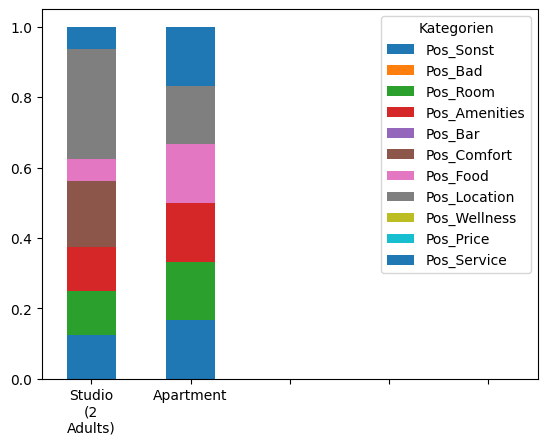

In [69]:
sonst=[]
bad=[]
room=[]
amen=[]
bar=[]
comf=[]
food=[]
loc=[]
well=[]
price=[]
service=[]
ind=[]
l=len(df_sub_month_gen["Room_Name"].value_counts().index.tolist())
for i in df_sub_month_gen["Room_Name"].value_counts().index.tolist():
    count2=df_sub_month_gen[(df_sub_month_gen["Room_Name"]==i)][["Pos_Sonst","Pos_Bad","Pos_Room","Pos_Amenities","Pos_Bar","Pos_Comfort","Pos_Food","Pos_Location","Pos_Wellness","Pos_Price","Pos_Service"]].copy()
    if count2["Pos_Sonst"].max()==1:
        sonst.append(count2["Pos_Sonst"].sum())
    else:
        sonst.append(0)
    if count2["Pos_Bad"].max()==1:
        bad.append(count2["Pos_Bad"].sum())
    else:
        bad.append(0)
    if count2["Pos_Room"].max()==1:
        room.append(count2["Pos_Room"].sum())
    else:
        room.append(0)
    if count2["Pos_Amenities"].max()==1:
        amen.append(count2["Pos_Amenities"].sum())
    else:
        amen.append(0)
    if count2["Pos_Bar"].max()==1:
        bar.append(count2["Pos_Bar"].sum())
    else:
        bar.append(0)
    if count2["Pos_Comfort"].max()==1:
        comf.append(count2["Pos_Comfort"].sum())
    else:
        comf.append(0)
    if count2["Pos_Food"].max()==1:
        food.append(count2["Pos_Food"].sum())
    else:
        food.append(0)
    if count2["Pos_Location"].max()==1:
        loc.append(count2["Pos_Location"].sum())
    else:
        loc.append(0)
    if count2["Pos_Wellness"].max()==1:
        well.append(count2["Pos_Wellness"].sum())
    else:
        well.append(0)
    if count2["Pos_Price"].max()==1:
        price.append(count2["Pos_Price"].sum())
    else:
        price.append(0)
    if count2["Pos_Service"].max()==1:
        service.append(count2["Pos_Service"].sum())
    else:
        service.append(0)
    ind.append(i)
sonst.extend([float('nan'),float('nan'),float('nan')])
bad.extend([float('nan'),float('nan'),float('nan')])
room.extend([float('nan'),float('nan'),float('nan')])
amen.extend([float('nan'),float('nan'),float('nan')])
bar.extend([float('nan'),float('nan'),float('nan')])
comf.extend([float('nan'),float('nan'),float('nan')])
food.extend([float('nan'),float('nan'),float('nan')])
loc.extend([float('nan'),float('nan'),float('nan')])
well.extend([float('nan'),float('nan'),float('nan')])
price.extend([float('nan'),float('nan'),float('nan')])
service.extend([float('nan'),float('nan'),float('nan')])
ind.extend(['','',''])
stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind)

### Negative Stack

In [70]:
def stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind):
    # create DataFrame
    labels=["Neg_Sonst","Neg_Bad","Neg_Room","Neg_Amenities","Neg_Bar","Neg_Comfort","Neg_Food","Neg_Location","Neg_Wellness","Neg_Price","Neg_Service"]
    df = pd.DataFrame({"Neg_Sonst":sonst,
                       "Neg_Bad":bad,
                       "Neg_Room":room,
                       "Neg_Amenities":amen,
                       "Neg_Bar":bar,
                       "Neg_Comfort":comf,
                       "Neg_Food":food,
                       "Neg_Location":loc,
                       "Neg_Wellness":well,
                       "Neg_Price":price,
                       "Neg_Service":service},
                      index=[label.replace(' ','\n') for label in ind])
    # Normalize the data: scale each row to sum to 1
    df_normalized = df.div(df.sum(axis=1), axis=0)
    # create stacked bar chart for monthly temperatures
    df_normalized.plot(kind='bar', stacked=True)
    plt.legend(labels, loc="upper right", title="Kategorien")
    #bbox_to_anchor=(1, 0.5)
    # labels for x & y axis
    #plt.xlabel('Months')
    plt.xticks(rotation=0)
    #plt.ylabel('Temp ranges in Degree Celsius')
    plt.savefig('../'+str(id)+"/Month_"+str(month)+"/neg_stack_room.png",bbox_inches='tight')
    # title of plot
    #plt.title('Monthly Temperatures in a year')

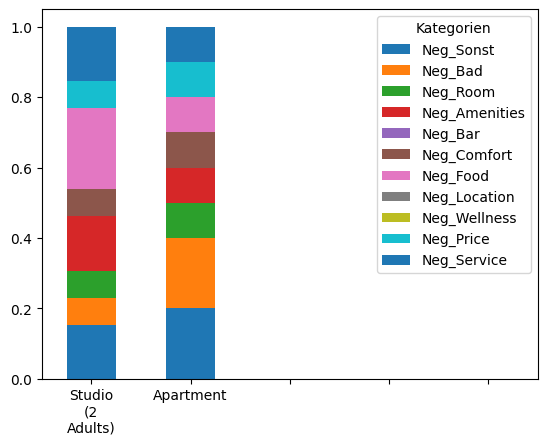

In [71]:
sonst=[]
bad=[]
room=[]
amen=[]
bar=[]
comf=[]
food=[]
loc=[]
well=[]
price=[]
service=[]
ind=[]
l=len(df_sub_month_gen["Room_Name"].value_counts().index.tolist())
for i in df_sub_month_gen["Room_Name"].value_counts().index.tolist():
    count2=df_sub_month_gen[(df_sub_month_gen["Room_Name"]==i)][["Neg_Sonst","Neg_Bad","Neg_Room","Neg_Amenities","Neg_Bar","Neg_Comfort","Neg_Food","Neg_Location","Neg_Wellness","Neg_Price","Neg_Service"]].copy()
    if count2["Neg_Sonst"].max()==1:
        sonst.append(count2["Neg_Sonst"].sum())
    else:
        sonst.append(0)
    if count2["Neg_Bad"].max()==1:
        bad.append(count2["Neg_Bad"].sum())
    else:
        bad.append(0)
    if count2["Neg_Room"].max()==1:
        room.append(count2["Neg_Room"].sum())
    else:
        room.append(0)
    if count2["Neg_Amenities"].max()==1:
        amen.append(count2["Neg_Amenities"].sum())
    else:
        amen.append(0)
    if count2["Neg_Bar"].max()==1:
        bar.append(count2["Neg_Bar"].sum())
    else:
        bar.append(0)
    if count2["Neg_Comfort"].max()==1:
        comf.append(count2["Neg_Comfort"].sum())
    else:
        comf.append(0)
    if count2["Neg_Food"].max()==1:
        food.append(count2["Neg_Food"].sum())
    else:
        food.append(0)
    if count2["Neg_Location"].max()==1:
        loc.append(count2["Neg_Location"].sum())
    else:
        loc.append(0)
    if count2["Neg_Wellness"].max()==1:
        well.append(count2["Neg_Wellness"].sum())
    else:
        well.append(0)
    if count2["Neg_Price"].max()==1:
        price.append(count2["Neg_Price"].sum())
    else:
        price.append(0)
    if count2["Neg_Service"].max()==1:
        service.append(count2["Neg_Service"].sum())
    else:
        service.append(0)
    ind.append(i)
sonst.extend([float('nan'),float('nan'),float('nan')])
bad.extend([float('nan'),float('nan'),float('nan')])
room.extend([float('nan'),float('nan'),float('nan')])
amen.extend([float('nan'),float('nan'),float('nan')])
bar.extend([float('nan'),float('nan'),float('nan')])
comf.extend([float('nan'),float('nan'),float('nan')])
food.extend([float('nan'),float('nan'),float('nan')])
loc.extend([float('nan'),float('nan'),float('nan')])
well.extend([float('nan'),float('nan'),float('nan')])
price.extend([float('nan'),float('nan'),float('nan')])
service.extend([float('nan'),float('nan'),float('nan')])
ind.extend(['','',''])
stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind)

# Saving Placeholder DataFrame in Excel File

In [72]:
# Speicher die neue Dataframe ab
placeholder_path='../'+str(id)+"/Month_"+str(month)+"/placeholder_month_"+str(month)+"_id_"+str(id)
df_placeholder.to_excel(placeholder_path+".xlsx")